In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/20220628/atlas_mm_vmm_bkgr_1_TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 200000/200000 [00:07<00:00, 28386.02it/s]


!!
I read 200000 events, of which 100000 have muon and 100000 do not
!!


In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

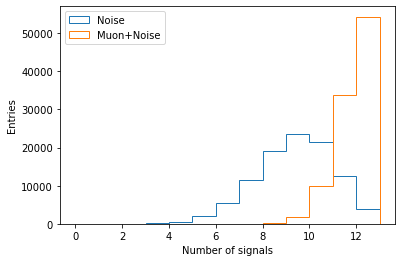

In [13]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], histtype='step', range=(0,13), bins=13, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', range=(0,13), bins=13, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

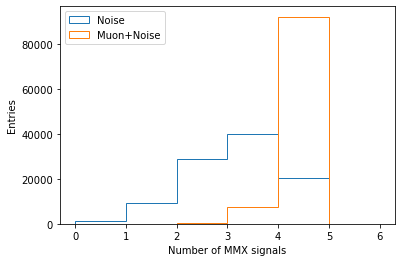

In [14]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

In [15]:
for ib in range(0,7):
    sig_eff = h_muons[0][ib:].sum()/h_muons[0].sum()
    bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())
    print('Minimum number of MMX signals:', ib)
    print('\t', 'Signal efficiency:', sig_eff)
    print('\t', 'Background rejection:', bkg_rej)

Minimum number of MMX signals: 0
	 Signal efficiency: 1.0
	 Background rejection: 1.0
Minimum number of MMX signals: 1
	 Signal efficiency: 1.0
	 Background rejection: 1.0118897040222616
Minimum number of MMX signals: 2
	 Signal efficiency: 0.99993
	 Background rejection: 1.1185181871057224
Minimum number of MMX signals: 3
	 Signal efficiency: 0.99778
	 Background rejection: 1.6559307158588483
Minimum number of MMX signals: 4
	 Signal efficiency: 0.92229
	 Background rejection: 4.927079227433977
Minimum number of MMX signals: 5
	 Signal efficiency: 0.0
	 Background rejection: inf
Minimum number of MMX signals: 6
	 Signal efficiency: 0.0
	 Background rejection: inf


<ipython-input-15-927cb1fc27ea>:3: RuntimeWarning: divide by zero encountered in double_scalars
  bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())


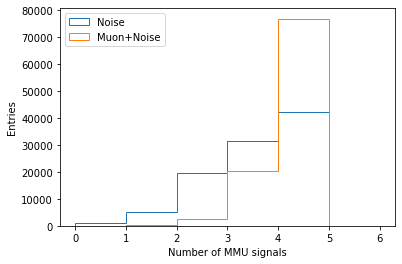

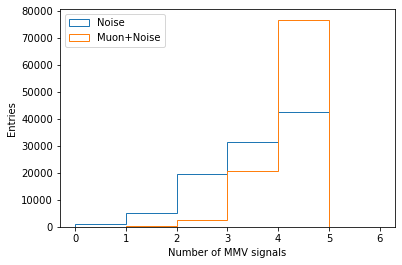

In [16]:
plt.Figure()
plt.hist(data['n_sig_mmu'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmu'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMU signals')
plt.ylabel('Entries')
plt.show()

plt.Figure()
plt.hist(data['n_sig_mmv'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmv'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMV signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [38]:
%ls -lhrt ../models/

total 138K
drwxr-sr-x 4 rafaeltl at 8.0K Jun 28 08:08 gru_BatchNormTrue_MaskingFalse_28062022_06.21.52/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 11:22 lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 23:35 gru_BatchNormFalse_MaskingFalse_28062022_06.00.14/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 01:18 lstm_BatchNormFalse_MaskingFalse_29062022_00.09.58/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 02:21 gru_BatchNormFalse_MaskingFalse_29062022_01.20.50/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  4 09:32 lstm_BatchNormFalse_MaskingFalse_04072022_09.00.14/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  4 10:12 lstm_BatchNormFalse_MaskingFalse_04072022_09.44.46/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 05:29 mlp_BatchNormFalse_MaskingFalse_05072022_05.27.55/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 06:08 tcn_BatchNormFalse_MaskingFalse_05072022_05.56.33_detMatrix/
drwxr-sr-x 4 rafaeltl at 4.0K Jul  5 08:37 lstm_BatchNormFalse_MaskingFalse_05072022_08.14.31_detMatrix/
drwxr-sr-x 4 rafaeltl at 8

In [63]:
mdict = {
    
    # "MLP":{
    #     "loc": "mlp_BatchNormFalse_MaskingFalse_05072022_05.27.55",
    #     "data_det": True,
    #     "data_card": "../../cards/atlas_mm_vmm.yml",
    #     "data_flat": True,
    #     "color": "C0",
    # },
    
    # "LSTM-pad":{
    #     "loc": "lstm_BatchNormFalse_MaskingFalse_04072022_09.44.46",
    #     "data_det": False,
    #     "data_card": "../../cards/atlas_mm_vmm.yml",
    #     "data_flat": False,
    #     "color": "C1",
    # },
    
    "LSTM-det":{
        "loc": "lstm_BatchNormFalse_MaskingFalse_04072022_09.00.14",
        "data_det": True,
        "data_card": "../../cards/atlas_mm_vmm.yml",
        "data_flat": False,
        "color": "C0",
    },
    
    "TCN-pad":{
        "loc": "tcn_BatchNormFalse_MaskingFalse_classification_20072022_02.56.43_normalMatrix",
        "data_det": False,
        "data_card": "../../cards/atlas_mm_vmm.yml",
        "data_flat": False,
        "color": "C1",
    },
    
    # "TCN-det":{
    #     "loc": "tcn_BatchNormFalse_MaskingFalse_05072022_05.56.33_detMatrix",
    #     "data_det": True,
    #     "data_card": "../../cards/atlas_mm_vmm.yml",
    #     "data_flat": False,
    #     "color": "C4",
    # },
    
    "TCN-pad-reg":{
        "loc": "tcn_BatchNormFalse_MaskingFalse_regression1_20072022_07.30.50_normalMatrix",
        "data_det": False,
        "data_card": "../../cards/atlas_mm_vmm.yml",
        "data_flat": False,
        "color": "C2",
        "class_out": 0
    }
}

In [64]:
import trainingvariables

In [65]:
for mod in mdict:
    
    if 'yhat' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if mdict[mod]['data_det']:
        X_prep = datatools.detector_matrix(dmat, sig_keys, mdict[mod]['data_card'])
    else:
        X_prep = datatools.training_prep(dmat, sig_keys)
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    X = X_prep[:,:,vars_of_interest]
    
    if mdict[mod]['data_flat']:
        X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    model_loc = '../models/'
    
    model = keras.models.load_model(model_loc+mdict[mod]['loc'],compile=False)
    
    if 'class_out' in mdict[mod]:
        mdict[mod]['yhat'] = model.predict(X, batch_size=1024)[:,mdict[mod]['class_out']]
    else:
        mdict[mod]['yhat'] = model.predict(X, batch_size=1024).flatten()

~~ Preparing detector-based data matrix ~~
Using detector card: ../../cards/atlas_mm_vmm.yml


100%|██████████| 200000/200000 [00:07<00:00, 25388.32it/s]


Output data matrix shape: (200000, 12, 19)
~~ Preparing padded matrix ~~
Data already prepared?


100%|██████████| 200000/200000 [00:07<00:00, 25788.29it/s]


Output data matrix shape: (200000, 12, 19)
~~ Preparing padded matrix ~~
Data already prepared?


100%|██████████| 200000/200000 [00:07<00:00, 25447.14it/s]


Output data matrix shape: (200000, 12, 19)


## Make plots

In [66]:
# yhat_x3 = np.copy(yhat)
# yhat_x3[data['n_sig_mmx']<4] = 0.0

# yhat_x2 = np.copy(yhat)
# yhat_x2[data['n_sig_mmx']<3] = 0.0

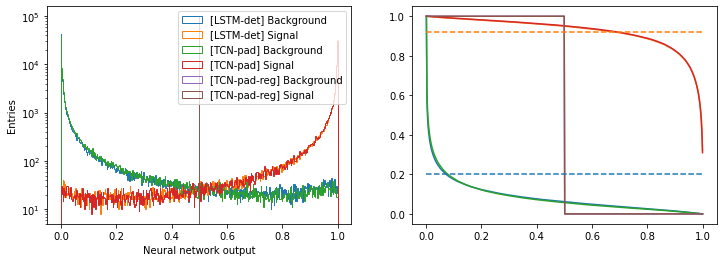

In [67]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

for mod in mdict:
    
    yhat=mdict[mod]['yhat']
    
    h_b = axs[0].hist(yhat[Y_mu==0], histtype='step', range=(0,1), bins=500, label=f'[{mod}] Background')
    h_s = axs[0].hist(yhat[Y_mu==1], histtype='step', range=(0,1), bins=500, label=f'[{mod}] Signal')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].set_xlabel('Neural network output')
    axs[0].set_ylabel('Entries')

    xaxs = 0.5*( h_b[1][1:] + h_b[1][:-1] )
    axs[1].plot(xaxs, h_b[0][::-1].cumsum()[::-1]/h_b[0].sum(), label=f'[{mod}] B efficiency')
    axs[1].plot(xaxs, h_s[0][::-1].cumsum()[::-1]/h_s[0].sum(), label=f'[{mod}] S efficiency')
    
axs[1].plot([0,1], [1/4.927079227433977, 1/4.927079227433977], '--', color='C0')
axs[1].plot([0,1], [0.92229, 0.92229], '--', color='C1')

# plt.savefig(model_loc+model_name+'/output_histogram.pdf')
plt.show()

<ipython-input-68-388c28aed5ad>:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(tpr, 1./fpr, label=f'[{mod}] Cut on NN', color=mdict[mod]['color'])
<ipython-input-68-388c28aed5ad>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(tpr_x3, 1./fpr_x3, '--', label=f'[{mod}] Cut on NN & '+r'$N_{MMX} > 3$', color=mdict[mod]['color'])
<ipython-input-68-388c28aed5ad>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(tpr_x2, 1./fpr_x2, ':', label=f'[{mod}] Cut on NN & '+r'$N_{MMX} > 2$', color=mdict[mod]['color'])
<ipython-input-68-388c28aed5ad>:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(tpr, 1./fpr, label=f'[{mod}] Cut on NN', color=mdict[mod]['color'])
<ipython-input-68-388c28aed5ad>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogy(tpr_x3, 1./fpr_x3, '--', label=f'[{mod}] Cut on NN & '+r'$N_{MMX} > 3$', color=mdict[mod]['color'])
<ipython-input-68-388c28a

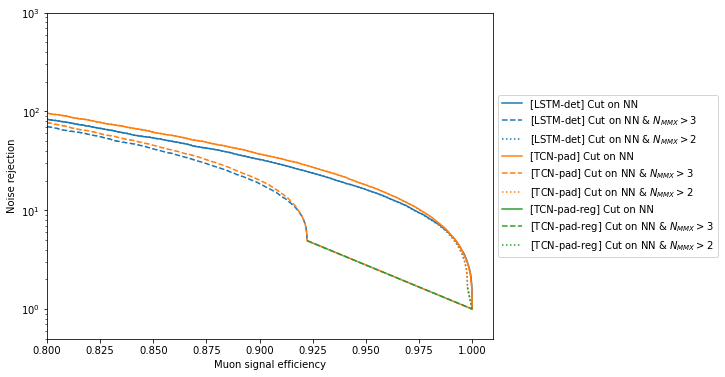

In [68]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for mod in mdict:
    
    yhat=mdict[mod]['yhat']
    yhat_x3 = np.copy(yhat)
    yhat_x3[data['n_sig_mmx']<4] = 0.0
    yhat_x2 = np.copy(yhat)
    yhat_x2[data['n_sig_mmx']<3] = 0.0

    fpr, tpr, thresholds = metrics.roc_curve(Y_mu, yhat)
    fpr_x3, tpr_x3, thresholds = metrics.roc_curve(Y_mu, yhat_x3)
    fpr_x2, tpr_x2, thresholds = metrics.roc_curve(Y_mu, yhat_x2)
    ax.semilogy(tpr, 1./fpr, label=f'[{mod}] Cut on NN', color=mdict[mod]['color'])
    ax.semilogy(tpr_x3, 1./fpr_x3, '--', label=f'[{mod}] Cut on NN & '+r'$N_{MMX} > 3$', color=mdict[mod]['color'])
    ax.semilogy(tpr_x2, 1./fpr_x2, ':', label=f'[{mod}] Cut on NN & '+r'$N_{MMX} > 2$', color=mdict[mod]['color'])

ax.set_xlim(0.8, 1.01)
ax.set_ylim(0.5, 1e3)
ax.set_xlabel('Muon signal efficiency')
ax.set_ylabel('Noise rejection')
ax.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig(model_loc+model_name+'/roc.pdf')
plt.show()